In [ ]:
!pip install -U pandas numpy scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 149.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 140.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: scikit-learn
    Found ex

##Importing libraries and Dataset

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
train_path = "airbnb_train.csv"
valid_path = "airbnb_valid.csv"
test_path  = "airbnb_test.csv"

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df  = pd.read_csv(test_path)

print(train_df.shape, valid_df.shape, test_df.shape)
train_df.head()


(47264, 22) (15755, 22) (15754, 22)


,index,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_since_review,has_review,log_price,log_number_reviews,log_host_listings,price_bucket_5
0,54311,27081524,Private Room in a Georgian Townhouse - Garden ...,103986360,Kiko,Tower Hamlets,51.52103,-0.07184,Private room,140,...,2000-01-01,1.68,5,350,0,0,4.948760,2.484907,1.791759,High
1,60905,29647162,Lovely Studio in Paddington large room and kit...,203336482,Gabriella,Westminster,51.51484,-0.17998,Private room,50,...,6-07-20,0.99,30,341,728093,1,3.931826,2.197225,3.433987,Low
2,3123,1856479,Exclusive GRoom in Knightsbridge,9424180,Stefan,Westminster,51.49908,-0.16482,Private room,109,...,2000-01-01,0.19,2,0,0,0,4.700480,2.639057,1.098612,High
3,31221,18460351,1 bedroom apartment in Notting Hill,61509654,Kelly,Kensington and Chelsea,51.51407,-0.19626,Entire home/apt,108,...,2000-01-01,0.04,1,0,0,0,4.691348,0.693147,0.693147,High
4,72301,33682195,Charming & Elegant Two Beds in Trendy Islington,97672150,Sophie,Islington,51.53411,-0.09883,Entire home/apt,225,...,7-01-20,3.10,6,120,727909,1,5.420535,2.302585,1.945910,Very High


**Data Preprocessing and Cleaning**

In [ ]:
TARGET = "price_bucket_5"

LEAKY_COLS = {"price", "log_price", TARGET}
INDEX_COLS = {"X", "Unnamed: 0", "index"}

drop_cols = list((LEAKY_COLS | INDEX_COLS) & set(train_df.columns))

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[TARGET]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[TARGET]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[TARGET]

print("Dropped columns:", drop_cols)


Dropped columns: ['price_bucket_5', 'log_price', 'index', 'price']


In [ ]:
NEIGHBOURHOOD_COLS = [
    "neighbourhood",
    "neighbourhood_cleansed",
    "neighbourhood_group",
    "neighbourhood_group_cleansed"
]

cols_to_drop = [c for c in NEIGHBOURHOOD_COLS if c in X_train.columns]

X_train = X_train.drop(columns=cols_to_drop)
X_valid = X_valid.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)

print("Dropped neighbourhood columns:", cols_to_drop)


Dropped neighbourhood columns: ['neighbourhood']


In [ ]:
classes = ["Very Low", "Low", "Medium", "High", "Very High"]

class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

def encode_y(y):
    return y.map(class_to_idx).astype(int).to_numpy()

y_train_enc = encode_y(y_train)
y_valid_enc = encode_y(y_valid)
y_test_enc  = encode_y(y_test)


print("Classes:", classes)


Classes: ['Very Low', 'Low', 'Medium', 'High', 'Very High']


In [ ]:
# Drop non-predictive / high-cardinality columns
DROP_COLS = [
    "name",
    "host_name",
    "last_review",
    "id",
    "host_id"
]

cols_to_drop = [c for c in DROP_COLS if c in X_train.columns]

X_train = X_train.drop(columns=cols_to_drop)
X_valid = X_valid.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)

print("Dropped non-predictive columns:", cols_to_drop)


Dropped non-predictive columns: ['name', 'host_name', 'last_review', 'id', 'host_id']


In [ ]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical:", cat_cols)
print("Numeric:", num_cols)


Categorical: ['room_type']
Numeric: ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'days_since_review', 'has_review', 'log_number_reviews', 'log_host_listings']


In [ ]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    )
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


In [ ]:
X_train_p = preprocessor.fit_transform(X_train)
X_valid_p = preprocessor.transform(X_valid)
X_test_p  = preprocessor.transform(X_test)

# Convert to dense
if hasattr(X_train_p, "toarray"):
    X_train_p = X_train_p.toarray()
    X_valid_p = X_valid_p.toarray()
    X_test_p  = X_test_p.toarray()


print("Transformed shapes:")
print("Train:", X_train_p.shape)
print("Valid:", X_valid_p.shape)
print("Test :", X_test_p.shape)


Transformed shapes:
Train: (47264, 14)
Valid: (15755, 14)
Test : (15754, 14)


**Functions for all models**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

def tpr_fpr_per_class(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    n = cm.shape[0]
    rows = []

    for i in range(n):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0

        rows.append({
            "Class": class_names[i],
            "TPR (Recall)": round(TPR, 4),
            "FPR": round(FPR, 4)
        })

    return rows


def plot_confusion_matrix(cm, class_names, title):
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_norm)

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(
                j, i,
                f"{cm_norm[i, j]:.2f}",
                ha="center",
                va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black"
            )

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


def evaluate(model, name, X, y_true, idx_to_class):

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)
    else:
        probs = model.predict(X, verbose=0)

    y_pred = np.argmax(probs, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    cm = confusion_matrix(y_true, y_pred)
    class_names = [str(idx_to_class[i]) for i in range(len(idx_to_class))]

    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("Macro F1:", round(f1m, 4))

    plot_confusion_matrix(
        cm,
        class_names,
        title=f"Normalised Confusion Matrix – {name}"
    )

    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=class_names,
            digits=4
        )
    )

    return tpr_fpr_per_class(y_true, y_pred, class_names)


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model, X, y_true, idx_to_class, title):


    # Number of classes
    n_classes = len(idx_to_class)

    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)
    else:
        y_score = model.predict(X, verbose=0)

    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(7, 6))
    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            lw=2,
            label=f"{idx_to_class[i]} (AUC = {roc_auc[i]:.2f})"
        )

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tpr_bar(df_tpr, model_name):


    classes = df_tpr["Class"].values
    tpr_values = df_tpr["TPR (Recall)"].values

    plt.figure(figsize=(8, 5))
    bars = plt.bar(classes, tpr_values)

    plt.ylim(0, 1)
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel("Price Category")
    plt.title(f"Class-wise TPR – {model_name} (Test Set)")
    plt.grid(axis="y", alpha=0.3)

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.2f}",
            ha="center",
            va="bottom"
        )

    plt.tight_layout()
    plt.show()


##Logistic Regression Model Group Baseline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


In [ ]:

log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)


In [ ]:
log_reg.fit(X_train_p, y_train_enc)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul


=== Logistic Regression – VALIDATION ===
Accuracy: 0.4334
Macro F1: 0.3718


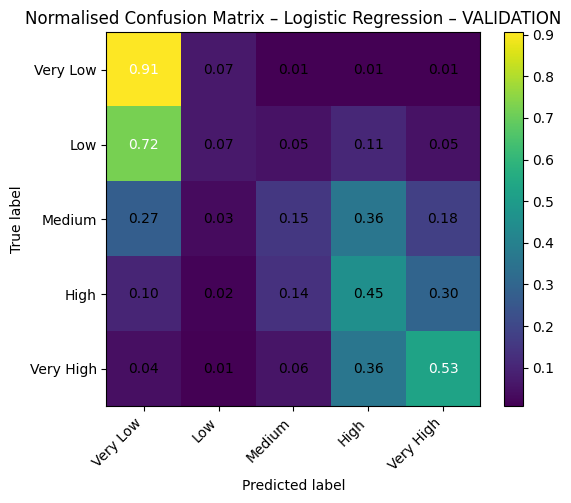


Classification report:
              precision    recall  f1-score   support

    Very Low     0.4779    0.9055    0.6256      3440
         Low     0.3158    0.0697    0.1143      2839
      Medium     0.3998    0.1513    0.2195      3352
        High     0.3375    0.4531    0.3869      3004
   Very High     0.4979    0.5282    0.5126      3120

    accuracy                         0.4334     15755
   macro avg     0.4058    0.4216    0.3718     15755
weighted avg     0.4093    0.4334    0.3792     15755



In [ ]:
tpr_fpr_lr_valid = evaluate(
    model=log_reg,
    name="Logistic Regression – VALIDATION",
    X=X_valid_p,
    y_true=y_valid_enc,
    idx_to_class=idx_to_class
)



=== Logistic Regression – TEST ===
Accuracy: 0.4393
Macro F1: 0.3751


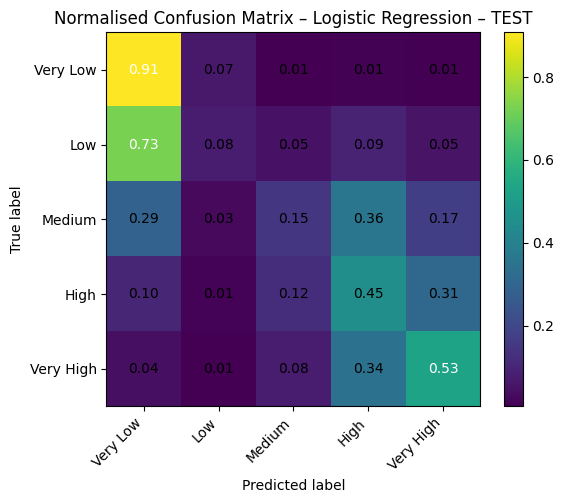


Classification report:
              precision    recall  f1-score   support

    Very Low     0.4837    0.9078    0.6311      3536
         Low     0.3462    0.0767    0.1255      2817
      Medium     0.3797    0.1469    0.2119      3253
        High     0.3553    0.4515    0.3977      3083
   Very High     0.4899    0.5302    0.5092      3065

    accuracy                         0.4393     15754
   macro avg     0.4109    0.4226    0.3751     15754
weighted avg     0.4137    0.4393    0.3848     15754



In [ ]:
tpr_fpr_lr_test = evaluate(
    model=log_reg,
    name="Logistic Regression – TEST",
    X=X_test_p,
    y_true=y_test_enc,
    idx_to_class=idx_to_class
)


In [ ]:
print("\nTPR / FPR per class (TEST – Model Logistic Regression):")
tpr_fpr_lr_test


TPR / FPR per class (TEST – Model Logistic Regression):


[{'Class': 'Very Low',
  'TPR (Recall)': np.float64(0.9078),
  'FPR': np.float64(0.2804)},
 {'Class': 'Low',
  'TPR (Recall)': np.float64(0.0767),
  'FPR': np.float64(0.0315)},
 {'Class': 'Medium',
  'TPR (Recall)': np.float64(0.1469),
  'FPR': np.float64(0.0625)},
 {'Class': 'High',
  'TPR (Recall)': np.float64(0.4515),
  'FPR': np.float64(0.1994)},
 {'Class': 'Very High',
  'TPR (Recall)': np.float64(0.5302),
  'FPR': np.float64(0.1333)}]

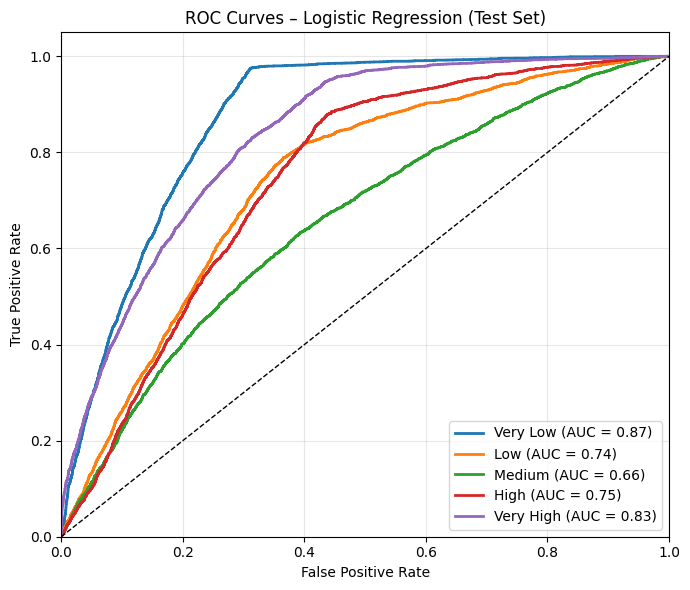

In [ ]:
roc_lr = plot_multiclass_roc(
    model=log_reg,
    X=X_test_p,
    y_true=y_test_enc,
    idx_to_class=idx_to_class,
    title="ROC Curves – Logistic Regression (Test Set)"
)


In [ ]:
coef_df = pd.DataFrame(
    log_reg.coef_,
    columns=[f"feature_{i}" for i in range(X_train_p.shape[1])],
    index=[idx_to_class[i] for i in range(len(idx_to_class))]
)

coef_df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
Very Low,0.006371,0.196982,0.202291,-0.141538,-0.005043,0.457232,-0.267297,0.021971,0.014897,0.288246,-0.157928,-2.773964,1.166506,1.932014
Low,0.012051,0.048796,0.028340,-0.013017,0.052937,-0.941269,-0.168832,0.000411,0.007599,0.101205,-0.021019,-0.840006,0.784591,0.205478
Medium,0.014084,0.004070,-0.066261,0.055530,-0.003379,0.018689,-0.042514,0.002216,0.001026,-0.013830,-0.102036,0.605093,-0.018553,-0.325367
High,0.018492,-0.070034,-0.109761,0.026962,0.002261,0.133174,0.113078,-0.014955,-0.008376,-0.082725,0.061619,1.400939,-0.672497,-0.974314
Very High,-0.050997,-0.179813,-0.054609,0.072062,-0.046777,0.332174,0.365565,-0.009643,-0.015146,-0.292896,0.219364,1.607938,-1.260047,-0.837811


##MLP Model A Baseline

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train_p.shape[1]
n_classes = len(classes)

model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,381 (146.02 KB)

 Trainable params: 37,381 (146.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_p, y_train_enc,
    validation_data=(X_valid_p, y_valid_enc),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.3891 - loss: 1.3573 - val_accuracy: 0.4540 - val_loss: 1.1899
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4571 - loss: 1.1907 - val_accuracy: 0.4689 - val_loss: 1.1752
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4685 - loss: 1.1748 - val_accuracy: 0.4752 - val_loss: 1.1659
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4737 - loss: 1.1658 - val_accuracy: 0.4819 - val_loss: 1.1596
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4768 - loss: 1.1597 - val_accuracy: 0.4851 - val_loss: 1.1520
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4823 - loss: 1.1536 - val_accuracy: 0.4854 - val_loss: 1.1477
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4842 - loss: 1.1449 - val_accuracy: 0.4891 - val_loss: 1.1443
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4891 - loss: 1.1427 - val_accuracy


=== MLP (A) Baseline – VALIDATION ===
Accuracy: 0.4997
Macro F1: 0.4844


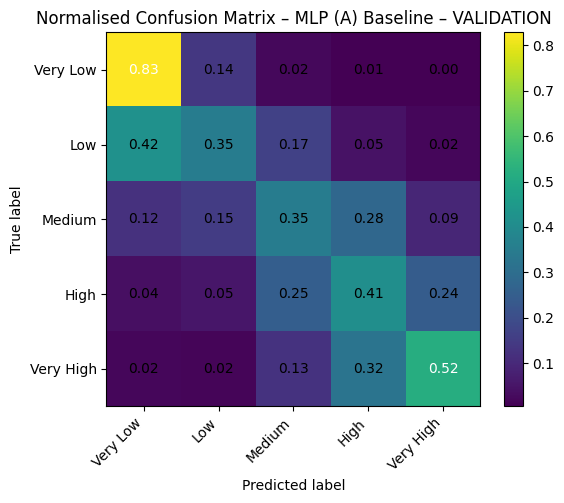


Classification report:
              precision    recall  f1-score   support

    Very Low     0.6154    0.8285    0.7062      3440
         Low     0.4532    0.3498    0.3948      2839
      Medium     0.4091    0.3505    0.3776      3352
        High     0.3718    0.4118    0.3908      3004
   Very High     0.5914    0.5183    0.5524      3120

    accuracy                         0.4997     15755
   macro avg     0.4882    0.4918    0.4844     15755
weighted avg     0.4911    0.4997    0.4896     15755



In [ ]:
tpr_fpr_A_valid = evaluate(
    model=model,
    name="MLP (A) Baseline – VALIDATION",
    X=X_valid_p,
    y_true=y_valid_enc,
    idx_to_class=idx_to_class
)



=== MLP (A) Baseline – TEST ===
Accuracy: 0.4993
Macro F1: 0.4815


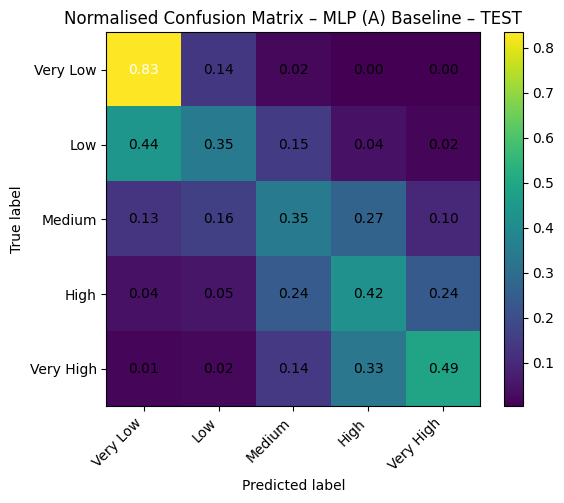


Classification report:
              precision    recall  f1-score   support

    Very Low     0.6179    0.8340    0.7098      3536
         Low     0.4419    0.3497    0.3904      2817
      Medium     0.4017    0.3474    0.3726      3253
        High     0.3915    0.4226    0.4065      3083
   Very High     0.5741    0.4891    0.5282      3065

    accuracy                         0.4993     15754
   macro avg     0.4854    0.4885    0.4815     15754
weighted avg     0.4890    0.4993    0.4884     15754



In [ ]:
tpr_fpr_A_test = evaluate(
    model=model,
    name="MLP (A) Baseline – TEST",
    X=X_test_p,
    y_true=y_test_enc,
    idx_to_class=idx_to_class
)


In [ ]:
print("\nTPR / FPR per class (TEST – Model MLP(A)):")
tpr_fpr_A_test



TPR / FPR per class (TEST – Model MLP(A)):


[{'Class': 'Very Low',
  'TPR (Recall)': np.float64(0.834),
  'FPR': np.float64(0.1493)},
 {'Class': 'Low',
  'TPR (Recall)': np.float64(0.3497),
  'FPR': np.float64(0.0962)},
 {'Class': 'Medium',
  'TPR (Recall)': np.float64(0.3474),
  'FPR': np.float64(0.1346)},
 {'Class': 'High',
  'TPR (Recall)': np.float64(0.4226),
  'FPR': np.float64(0.1598)},
 {'Class': 'Very High',
  'TPR (Recall)': np.float64(0.4891),
  'FPR': np.float64(0.0876)}]

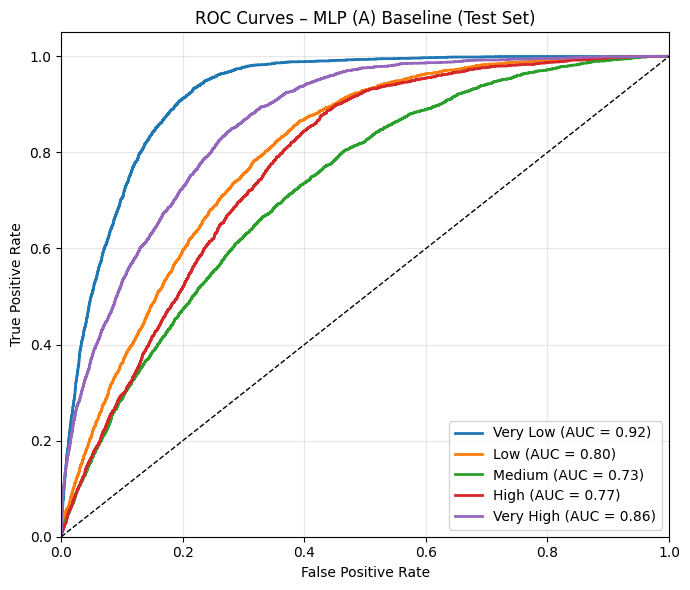

In [ ]:
roc_mlp_A = plot_multiclass_roc(
    model=model,
    X=X_test_p,
    y_true=y_test_enc,
    idx_to_class=idx_to_class,
    title="ROC Curves – MLP (A) Baseline (Test Set)"
)


##MLP Model B with Regularization

In [ ]:
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow import keras

def build_mlp_B(n_features, n_classes, hidden_units, learning_rate, l2_strength):
    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(
            hidden_units,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_strength)
        ),
        layers.Dropout(0.3),
        layers.Dense(
            hidden_units // 2,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_strength)
        ),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score

tf.random.set_seed(42)
np.random.seed(42)

param_grid = {
    "learning_rate": [1e-3, 5e-4],
    "l2_strength": [1e-4, 5e-4],
    "hidden_units": [128, 256]
}

results = []

n_features = X_train_p.shape[1]
n_classes = len(idx_to_class)

for lr in param_grid["learning_rate"]:
    for l2 in param_grid["l2_strength"]:
        for hu in param_grid["hidden_units"]:

            print(f"Training MLP (B): LR={lr}, L2={l2}, Units={hu}")

            model = build_mlp_B(
                n_features=n_features,
                n_classes=n_classes,
                hidden_units=hu,
                learning_rate=lr,
                l2_strength=l2
            )

            early_stop = keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=5,
                restore_best_weights=True
            )

            model.fit(
                X_train_p,
                y_train_enc,
                validation_data=(X_valid_p, y_valid_enc),
                epochs=50,
                batch_size=256,
                callbacks=[early_stop],
                verbose=0
            )

            probs = model.predict(X_valid_p, verbose=0)
            preds = probs.argmax(axis=1)

            results.append({
                "learning_rate": lr,
                "l2_strength": l2,
                "hidden_units": hu,
                "val_accuracy": accuracy_score(y_valid_enc, preds),
                "val_macro_f1": f1_score(y_valid_enc, preds, average="macro")
            })


Training MLP (B): LR=0.001, L2=0.0001, Units=128
Training MLP (B): LR=0.001, L2=0.0001, Units=256
Training MLP (B): LR=0.001, L2=0.0005, Units=128
Training MLP (B): LR=0.001, L2=0.0005, Units=256
Training MLP (B): LR=0.0005, L2=0.0001, Units=128
Training MLP (B): LR=0.0005, L2=0.0001, Units=256
Training MLP (B): LR=0.0005, L2=0.0005, Units=128
Training MLP (B): LR=0.0005, L2=0.0005, Units=256


In [ ]:
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(
    "val_macro_f1",
    ascending=False
).iloc[0]

print("Best hyperparameters from grid search:")
print(best_params)


Best hyperparameters from grid search:
learning_rate      0.001000
l2_strength        0.000100
hidden_units     256.000000
val_accuracy       0.498128
val_macro_f1       0.481270
Name: 1, dtype: float64


In [ ]:
print(
    f"\nUsing: hidden_units={int(best_params['hidden_units'])}, "
    f"learning_rate={best_params['learning_rate']}, "
    f"l2_strength={best_params['l2_strength']}"
)



Using: hidden_units=256, learning_rate=0.001, l2_strength=0.0001


In [ ]:
mlp_B = build_mlp_B(
    n_features=n_features,
    n_classes=n_classes,
    hidden_units=int(best_params["hidden_units"]),
    learning_rate=best_params["learning_rate"],
    l2_strength=best_params["l2_strength"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)



In [ ]:
history_B = mlp_B.fit(
    X_train_p,
    y_train_enc,
    validation_data=(X_valid_p, y_valid_enc),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3780 - loss: 1.3988 - val_accuracy: 0.4549 - val_loss: 1.2084
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4574 - loss: 1.2109 - val_accuracy: 0.4681 - val_loss: 1.1932
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4677 - loss: 1.1953 - val_accuracy: 0.4781 - val_loss: 1.1827
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4739 - loss: 1.1840 - val_accuracy: 0.4804 - val_loss: 1.1769
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4777 - loss: 1.1749 - val_accuracy: 0.4866 - val_loss: 1.1691
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4824 - loss: 1.1688 - val_accuracy: 0.4877 - val_loss: 1.1638
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4838 - loss: 1.1647 - val_accuracy: 0.4870 - val_loss: 1.1617
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4872 - loss: 1.1602 - val_accuracy: 0


=== MLP (B) Regularised – VALIDATION ===
Accuracy: 0.4998
Macro F1: 0.4829


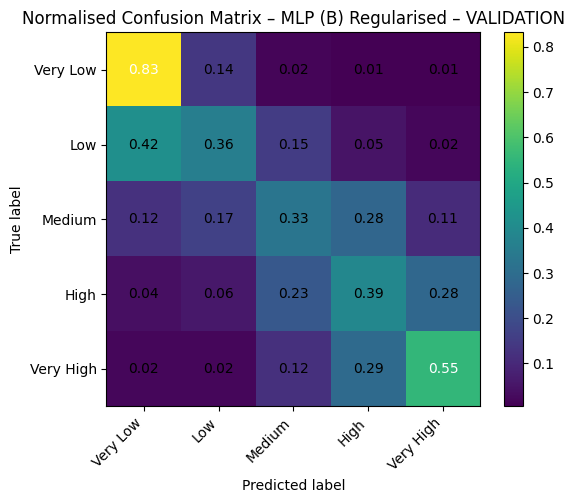


Classification report:
              precision    recall  f1-score   support

    Very Low     0.6171    0.8320    0.7086      3440
         Low     0.4446    0.3593    0.3974      2839
      Medium     0.4129    0.3282    0.3657      3352
        High     0.3688    0.3888    0.3785      3004
   Very High     0.5762    0.5526    0.5641      3120

    accuracy                         0.4998     15755
   macro avg     0.4839    0.4922    0.4829     15755
weighted avg     0.4871    0.4998    0.4880     15755



In [ ]:
tpr_fpr_B_valid = evaluate(
    mlp_B,
    name="MLP (B) Regularised – VALIDATION",
    X=X_valid_p,
    y_true=y_valid_enc,
    idx_to_class=idx_to_class
)



=== MLP (B) Regularised – TEST ===
Accuracy: 0.4965
Macro F1: 0.4771


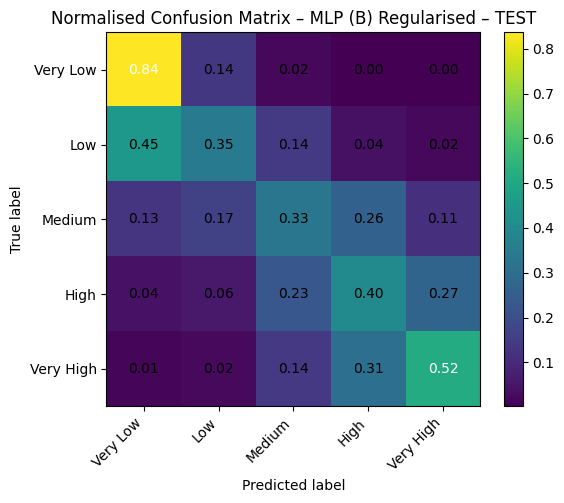


Classification report:
              precision    recall  f1-score   support

    Very Low     0.6151    0.8365    0.7089      3536
         Low     0.4345    0.3486    0.3868      2817
      Medium     0.4009    0.3302    0.3621      3253
        High     0.3892    0.3970    0.3931      3083
   Very High     0.5537    0.5168    0.5346      3065

    accuracy                         0.4965     15754
   macro avg     0.4787    0.4858    0.4771     15754
weighted avg     0.4824    0.4965    0.4840     15754



In [ ]:
tpr_fpr_B_test = evaluate(
    mlp_B,
    name="MLP (B) Regularised – TEST",
    X=X_test_p,
    y_true=y_test_enc,
    idx_to_class=idx_to_class
)


In [ ]:
print("\nTPR / FPR per class (TEST – Model MLP(B)):")
tpr_fpr_B_test



TPR / FPR per class (TEST – Model MLP(B)):


[{'Class': 'Very Low',
  'TPR (Recall)': np.float64(0.8365),
  'FPR': np.float64(0.1515)},
 {'Class': 'Low',
  'TPR (Recall)': np.float64(0.3486),
  'FPR': np.float64(0.0988)},
 {'Class': 'Medium',
  'TPR (Recall)': np.float64(0.3302),
  'FPR': np.float64(0.1284)},
 {'Class': 'High',
  'TPR (Recall)': np.float64(0.397),
  'FPR': np.float64(0.1516)},
 {'Class': 'Very High',
  'TPR (Recall)': np.float64(0.5168),
  'FPR': np.float64(0.1006)}]

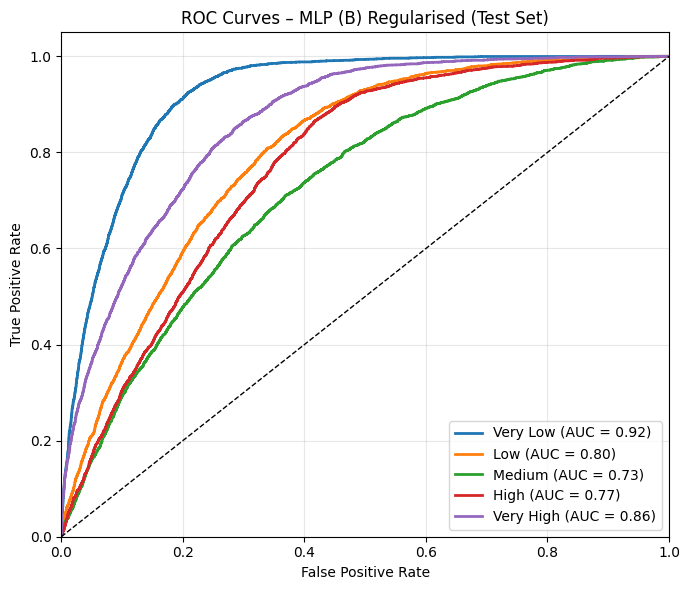

In [ ]:
roc_mlp_B = plot_multiclass_roc(
    model=mlp_B,
    X=X_test_p,
    y_true=y_test_enc,
    idx_to_class=idx_to_class,
    title="ROC Curves – MLP (B) Regularised (Test Set)"
)


#Barplot for tpr/fpr

In [ ]:
import pandas as pd

tpr_fpr_lr_test = pd.DataFrame(tpr_fpr_lr_test)
tpr_fpr_mlpA_test = pd.DataFrame(tpr_fpr_A_test)
tpr_fpr_mlpB_test = pd.DataFrame(tpr_fpr_B_test)


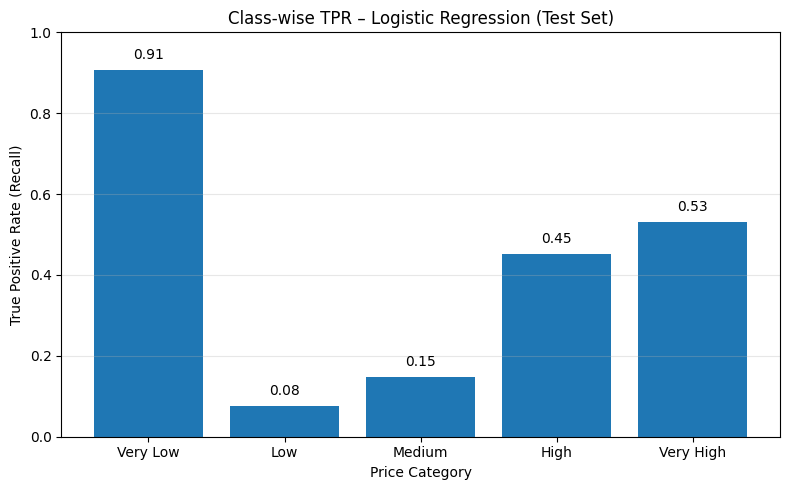

In [ ]:
plot_tpr_bar(tpr_fpr_lr_test, "Logistic Regression")


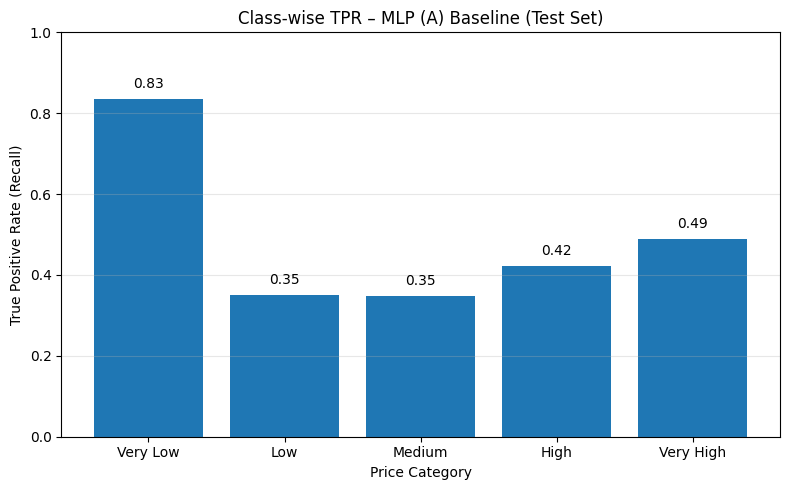

In [ ]:
plot_tpr_bar(tpr_fpr_mlpA_test, "MLP (A) Baseline")


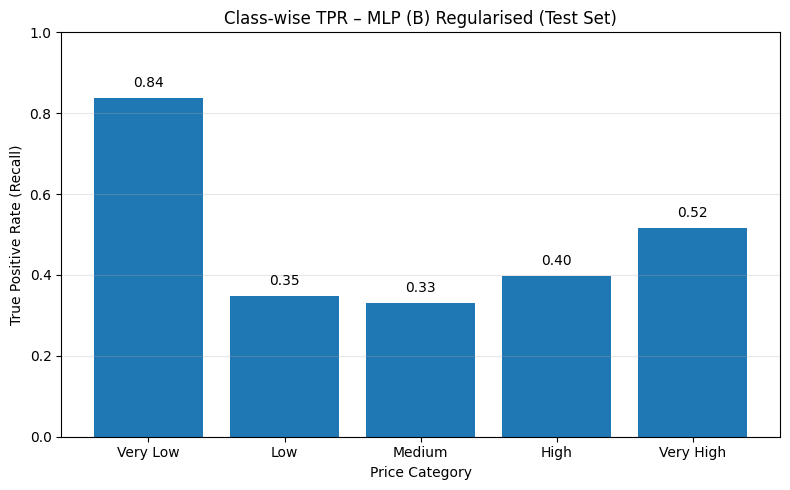

In [ ]:
plot_tpr_bar(tpr_fpr_mlpB_test, "MLP (B) Regularised")
